# MLFLOW het opslaan van onze trainingsgegevens

In deze notebook zorgen wij voor een set van trainingsiteraties waarop wij een selectie maken van optimale features per model.

doel: genoeg iteraties van trainingen zodat wij kunnen bepalen wat het best werkt per model (wox/geen wox * thomas/erwin)

In [3]:
# importeren packages
import pandas as pd
import numpy as np
import xgboost
import pickle
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import xgboost
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, StratifiedKFold
import mlflow
from matplotlib import pyplot


In [4]:
# setten source path: later moet alle brondata naar datalake
source_path ="P:\\DATASCIENCE\\Aantrekkelijkheid buurten\\Resultaten\\"
# alle tussentijdse data voorlopig in dezelfde map op een schijf opslaan in
save_path = "P:\\DATASCIENCE\\Aantrekkelijkheid buurten\\Resultaten\\"

In [5]:
# inladen bestand met alle buurten en onafhankelijke variabelen als all
buurtendata = pd.read_csv(source_path + 'buurten.csv', encoding='utf-16')
buurtendata.rename(columns={"RLBBEV18":"RLBBEV",'KL18': "KL", 
               'RLBRMTR18': 'RLBRMTR', 'RLBWON18':'RLBWON' , 'RLBBEV18':'RLBBEV', 'RLBVRZ18':'RLBVRZ', 'RLBVEI18': 'RLBVEI', 'RLBFYS18': 'RLBFYS',}, inplace=True) 

In [6]:
# inladen bestand met scores als sc
sc = pd.read_excel(source_path + 'buurten voor experts 2e ronde.xlsx', sheet_name='buurten')
# alleen selecteren kolommen voor scores en oordelen
sc = sc[['buurtcode','EE','TK']]

In [7]:
df = pd.merge(sc, buurtendata, on='buurtcode')

In [8]:
# minus de kolommen die niet in de 2016 dataset aanwezig zijn
feature_cols = ['AantalCafe3', 'woxdelta5jr', 'woxm2', 'woxww',
       'woxdelta5jrGem', 'wox', 'RLBBEV',
       'RLBVRZ', 'AantalLevensm3', 'woxm2WG', 'aand1945-1970',
       'woxdelta5jrWGabs', 'woxdelta1jrGem', 'AantalPodiumk10',
       'wv2000-2010', 'AantalBios5']
       
X = df[feature_cols]
y = df['EE']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [10]:
# maak object met geoptimaliseerde hyperparameters
model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.15, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2,
              silent=None, subsample=0.8, verbosity=1)

# en fit op data

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=30, eval_metric=["merror", "mlogloss"])

[0]	validation_0-merror:0.06719	validation_0-mlogloss:0.93583	validation_1-merror:0.15294	validation_1-mlogloss:0.95729
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-merror:0.05138	validation_0-mlogloss:0.80975	validation_1-merror:0.11765	validation_1-mlogloss:0.84293
[2]	validation_0-merror:0.04348	validation_0-mlogloss:0.70637	validation_1-merror:0.10588	validation_1-mlogloss:0.75408
[3]	validation_0-merror:0.04348	validation_0-mlogloss:0.62384	validation_1-merror:0.11765	validation_1-mlogloss:0.68186
[4]	validation_0-merror:0.04348	validation_0-mlogloss:0.55372	validation_1-merror:0.09412	validation_1-mlogloss:0.61679
[5]	validation_0-merror:0.03953	validation_0-mlogloss:0.49745	validation_1-merror:0.10588	validation_1-mlogloss:0.56739
[6]	validation_0-merror:0.03953	validation_0-mlogloss:0.44594	validation_1-merror:0.10588	validation_1-mlogloss:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=2, silent=None,
              subsample=0.8, tree_method=None, validate_parameters=False,
              verbosity=1)

In [11]:
model.best_iteration

109

In [12]:
model.best_score

0.216385

In [13]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred)
print(train_accuracy, '\n',test_accuracy,'\n', cm)

0.9881422924901185 
 0.9176470588235294 
 [[38  1  0]
 [ 3 25  2]
 [ 1  0 15]]


In [14]:
fi = pd.DataFrame(model.feature_importances_,X_train.columns)
fi.columns = ['feature_score']
fi.sort_values('feature_score', ascending=False, inplace=True)
#fi['feature'] = fi.index
fi

,feature_score
woxm2,0.212593
woxww,0.151663
woxdelta1jrGem,0.106258
woxm2WG,0.101809
AantalPodiumk10,0.077622
wox,0.071585
woxdelta5jr,0.062304
woxdelta5jrWGabs,0.034631
wv2000-2010,0.029706
RLBBEV,0.028097


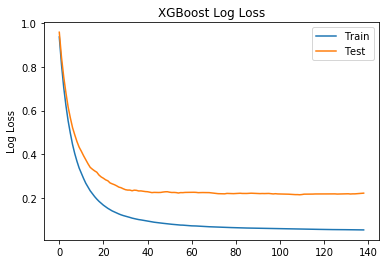

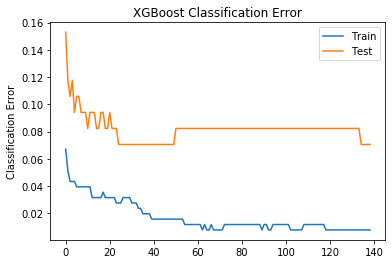

In [15]:
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
#plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [16]:
fig.savefig('error.png')

## Experiment opzetten
Hier testen we of we via MLFlow een experiment kunnen runnen

In [17]:
Experiment_name = 'buurtscores model'
run_naam = 'Alex gesneden features'

#-----------------------
target_col = 'TK'
seed = 50

# minus de kolommen die niet in de 2016 dataset aanwezig zijn
feature_cols = ['AantalCafe3', 'woxdelta5jr', 'woxm2', 'woxww',
       'woxdelta5jrGem', 'wox', 'RLBBEV',
       'RLBVRZ', 'AantalLevensm3', 'woxm2WG', 'aand1945-1970',
       'woxdelta5jrWGabs', 'woxdelta1jrGem', 'AantalPodiumk10',
       'wv2000-2010', 'AantalBios5']
       
X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

mlflow.set_experiment(Experiment_name)

[0]	validation_0-merror:0.07510	validation_0-mlogloss:0.94078	validation_1-merror:0.18824	validation_1-mlogloss:0.97198
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.07510	validation_0-mlogloss:0.81450	validation_1-merror:0.17647	validation_1-mlogloss:0.86707
[2]	validation_0-merror:0.07510	validation_0-mlogloss:0.71669	validation_1-merror:0.16471	validation_1-mlogloss:0.79205
[3]	validation_0-merror:0.06324	validation_0-mlogloss:0.63639	validation_1-merror:0.14118	validation_1-mlogloss:0.72915
[4]	validation_0-merror:0.05534	validation_0-mlogloss:0.56775	validation_1-merror:0.16471	validation_1-mlogloss:0.68437
[5]	validation_0-merror:0.05138	validation_0-mlogloss:0.50885	validation_1-merror:0.16471	validation_1-mlogloss:0.63964
[6]	validation_0-merror:0.05138	validation_0-mlogloss:0.46277	validation_1-merror:0.16471	validation_1-mlogloss:0

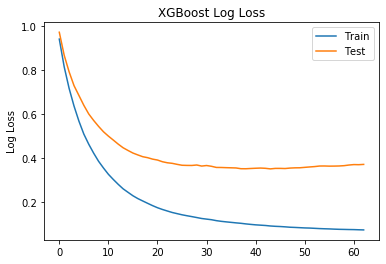

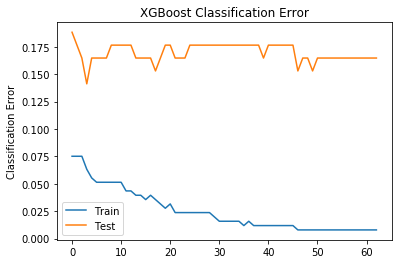

........ run finished ........


In [18]:
if __name__ == '__main__':
    mlflow.start_run(run_name=run_naam)
    model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.15, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=seed,
              silent=None, subsample=0.8, verbosity=1)

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, eval_metric=["merror", "mlogloss"], verbose = True)

    best_iteration, best_error = model.best_iteration, model.best_score

    # Accuracies opslaan
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    test_accuracy = accuracy_score(y_test,y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(train_accuracy, '\n',test_accuracy,'\n', cm)
    
    #parameters, metrics en artifacts vastleggen
    mlflow.log_param('Features', feature_cols)
    mlflow.log_param('Target Col', target_col)
    mlflow.log_metric('best_score', model.best_score)
    mlflow.log_metric('best_iteration', model.best_iteration)
    mlflow.log_metric('train_accuracy', train_accuracy)
    mlflow.log_metric('test_accuracy', test_accuracy)
    mlflow.log_metric('seed', seed)

    # Hier slaan we output informatie op
    file_dir = ("output/" + Experiment_name.replace(" ","_")+"/")
    for directory in file_dir:
        try: shutil.rmtree(file_dir)
        except: continue
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    
    # De hyperparameters opslaan van het model
    with open(file_dir+"/model_summary.txt","w+") as f:
        print(model, file=f)

    # Belangrijkheid van features opslaan
    with open(file_dir+"/feature_summary.txt","w+") as f:
        
        fi = pd.DataFrame(model.feature_importances_,X_train.columns)
        fi.columns = ['feature_score']
        fi.sort_values('feature_score', ascending=False, inplace=True)
        fi['feature'] = fi.index
        print(fi, file=f)

    # Figuren
    results = model.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)

    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()
    # opslaan
    fig.savefig(file_dir+'XGBoost MLogLoss.png', dpi=500)
    

    #plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()
    fig.savefig(file_dir+'XGBoost MError.png',  dpi=500)
    
    mlflow.log_artifacts(file_dir)

    mlflow.end_run()
    print('........ run finished ........')

In [19]:
mlflow.end_run()

# Cross validation
Via Cross validation kunnen wij testen wat de echte impact van ons model is. Via random initiatie/ verdeling van de training en test set zit er namelijk redelijk veel verschil (~ 5 %!)

## Cross Valdidation experiment
Hier hebben wij nog veel meer runs gedaan om de impact van ruis / verdelen van de folds te minimaliseren

In [191]:
Experiment_name = 'buurtscores cv'
run_naam = 'features selecteren'

target_col = 'EE'
seed = 50

# minus de kolommen die niet in de 2016 dataset aanwezig zijn
feature_cols = ['AantalCafe3', 'woxdelta5jr', 'woxm2', 'woxww',
       'woxdelta5jrGem', 'wox', 'RLBBEV',
       'RLBVRZ', 'AantalLevensm3', 'woxm2WG', 'aand1945-1970',
       'woxdelta5jrWGabs', 'woxdelta1jrGem', 'AantalPodiumk10',
       'wv2000-2010', 'd_overig',
       'd_optioneel', 'd_kern']


X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

mlflow.set_experiment(Experiment_name)

In [192]:
# We gebruiken stratified zodat in elke fold een goede verdeling is van onze outcome labels. 
skf = StratifiedKFold(n_splits=4, shuffle = True)
skf.get_n_splits(X, y)

4

In [193]:
if __name__ == '__main__':
    mlflow.start_run(run_name=run_naam)

    feature_imps = pd.DataFrame(index = feature_cols)
    cv_train_results, cv_test_results, iteration = [],[], 1
    for train_index, test_index in skf.split(X,y):
        print(f"\n---- Iteration {iteration}/{skf.get_n_splits(X, y) }")
        # Testen hoe de verhouding van labels is
        print(pd.DataFrame({"train ratio": y_train.value_counts()/len(y_train), 'test ratio': y_test.value_counts()/len(y_test)}))

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create a new model for this iteration
        model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
                learning_rate=0.15, max_delta_step=0, max_depth=7,
                min_child_weight=3, missing=None, n_estimators=250, n_jobs=1,
                nthread=None, objective='multi:softprob', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=seed,
                silent=None, subsample=0.8, verbosity=1)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, verbose= False)

        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)

        train_accuracy = accuracy_score(y_train,y_train_pred)
        test_accuracy = accuracy_score(y_test,y_pred)
        cm = confusion_matrix(y_test, y_pred)
        print(train_accuracy, '\n',test_accuracy,'\n', cm)

        # Het opslaan van onze cross-validatie resultaten.
        cv_train_results.append(train_accuracy)
        cv_test_results.append(test_accuracy)

        fi = pd.DataFrame(model.feature_importances_,X_train.columns)
        fi.columns = ['feature_score']
        fi.sort_values('feature_score', ascending=False, inplace=True)

        feature_imps = feature_imps.merge(fi, left_index = True, right_index = True, suffixes = (str(iteration-1), str(iteration))) # pas vanaf iteratie 2 overlap dus -1
        iteration += 1 

    # Gemiddelde en Std van onze resultaten.
    print(feature_imps)
    cv_train_mean_result, cv_train_std_result = np.mean(cv_train_results), np.std(cv_train_results)
    cv_test_mean_results, cv_test_std_results = np.mean(cv_test_results), np.std(cv_test_results)
    feature_imps = feature_imps.apply(np.mean, axis = 1).sort_values(ascending=False) # per fold slaan we dit op en nu middelen we deze

    #parameters, metrics en artifacts vastleggen
    mlflow.log_param('Features', feature_cols)
    mlflow.log_param('Target Col', target_col)
    mlflow.log_param('seed', seed)
    mlflow.log_param('folds', skf.get_n_splits(X, y))
    mlflow.log_metric('cv train mean', cv_train_mean_result)
    mlflow.log_metric('cv train std', cv_train_std_result)
    mlflow.log_metric('cv test mean', cv_test_mean_results)
    mlflow.log_metric('cv test std', cv_test_std_results)
    
    # Hier slaan we output informatie op
    file_dir = ("output/" + Experiment_name.replace(" ","_")+"/")
    for directory in file_dir:
        try: shutil.rmtree(file_dir)
        except: continue
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    
    # De hyperparameters opslaan van het model
    with open(file_dir+"/model_summary.txt","w+") as f:
        print(model, file = f)

    # Belangrijkheid van features opslaan
    with open(file_dir+"/feature_summary.txt","w+") as f:
        print(feature_imps, file=f)
    
    mlflow.log_artifacts(file_dir)
    mlflow.end_run()
    print('........ run finished ........')


---- Iteration 1/4
   train ratio  test ratio
a     0.462451    0.494118
b     0.308300    0.282353
c     0.229249    0.223529
0.9682539682539683 
 0.9302325581395349 
 [[38  2  0]
 [ 1 23  2]
 [ 1  0 19]]

---- Iteration 2/4
   train ratio  test ratio
a     0.472222    0.465116
b     0.301587    0.302326
c     0.226190    0.232558
0.9525691699604744 
 0.9294117647058824 
 [[37  3  0]
 [ 2 24  0]
 [ 0  1 18]]

---- Iteration 3/4
   train ratio  test ratio
a     0.470356    0.470588
b     0.300395    0.305882
c     0.229249    0.223529
0.9488188976377953 
 0.9047619047619048 
 [[40  0  0]
 [ 2 22  1]
 [ 1  4 14]]

---- Iteration 4/4
   train ratio  test ratio
a     0.468504    0.476190
b     0.303150    0.297619
c     0.228346    0.226190
0.9568627450980393 
 0.9156626506024096 
 [[36  3  0]
 [ 1 22  2]
 [ 0  1 18]]
                  feature_score1  feature_score2  feature_score3  \
AantalCafe3             0.028855        0.026177        0.033835   
woxdelta5jr             0.033161    

In [28]:
mlflow.end_run()

# Cross validation met veel variatie in seeds
Wij noteren heel veel variatie wat betreft de verdelingen in folds / train en test sets. Om tot een goed resultaat te komen over alle data met alle soorten verdelingen spelen wij hiermee.

Hieronder vinden wij ook variatie in kolommen omdat wij testen voor de 4 modellen (wox/geen * erwin/thomas)

De resultaten hiervan zijn geinterpreteerd via MLFLOW

In [19]:
# gtrends_data = pd.read_csv('P:\\DATASCIENCE\\Aantrekkelijkheid buurten\\Brondata\\buurtcodes_googletrend_info.csv')
# df = pd.merge(df,gtrends_data, on ='buurtcode')
# feature_cols = ['inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL',
#                'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 
#                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
#                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
#                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
#                'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 
#                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 
#                'woxGem', 'woxdelta1jrGem', 'woxdelta5jrGem', 'woxwwGem', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 
#                'woxm2WG','banen', 'prophet_next_year-Beauty&Fitness','prophet_next_year-RealEstate'] 

In [106]:
Experiment_name = 'buurtscores cv finalizen'
run_naam = 'wox feature filtering'

target_col = 'TK'

## Alles
# feature_cols = ['inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL', 
#                'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 
#                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
#                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
#                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
#                'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 
#                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 
#                'woxGem', 'woxdelta1jrGem', 'woxdelta5jrGem', 'woxwwGem', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 
#                'woxm2WG','banen'] 
               
## EE wox filterd.               
# feature_cols = ['oadh', 'KL', 
#                'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 
#                'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 
#                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
#                'aandeelMH19', 'auto30', 'ov30', 'fiets', 
#                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 
#                'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 
#                'woxm2WG','banen'] 

# feature_cols = ['bevdh', 'oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'aandeelMH19', 'auto30', 'ov30', 'fiets', 'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 'woxm2WG', 'banen']


# feature_cols = ['bevdh', 'oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'aandeelMH19', 'auto30', 'ov30', 'fiets', 'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 'woxm2WG', 'banen']

# ## TK wox gefilterd:

# feature_cols = ['AantalLevensm3','AantalCafe3',  'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'auto60', 'ov30', 'ov60', 'fiets', 'wox', 'woxdelta5jr', 'woxww', 'woxm2', 'woxGem', 'woxdelta5jrGem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 'woxm2WG', 'banen']         
# feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'aandeelMH19', 'auto30', 'ov30', 'fiets', 'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 'woxm2WG', 'banen']  

# feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'aandeelMH19', 'auto30', 'ov30', 'fiets', 'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 'woxm2WG', 'banen']

#zonder wox ALLES:
# feature_cols = ['inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL',
#                'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 
#                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
#                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
#                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
#                'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 'banen'] 

# #zonder wox gefilterd TK:
feature_cols = [ 'KL',
               'RLBRMTR', 'RLBBEV', 'RLBVRZ', 'AantalLevensm3', 'AantalCafe3','AantalRest3',  
               'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
                'hh19inkHoog', 
               'auto30', 'ov30', 'fiets', 'banen'] 
# feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3'
#                 , 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'hh19inkHoog', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 'banen']

# feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBFYS', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'hh19inkHoog', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 'banen']

# feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBFYS', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'hh19inkHoog', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 'banen']

# #zonder wox gefilterd EE:
# feature_cols = 		['inw', 'oadh', 'inw65', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 'banen','d_overig','d_optioneel','d_kern']

# feature_cols = ['inw', 'oadh', 'inw65', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 'banen']

# feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBFYS', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'hh19inkMidden', 'hh19inkHoog', 'aandeelMH19', 'auto30', 'ov30', 'fiets', 'banen', 'd_kern']
# feature_cols  = 	['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBFYS', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 'aandeelMH19', 'auto30', 'auto60', 'ov30', 'fiets', 'banen', 'd_kern']

X = df[feature_cols]
y = df[target_col]

random_seeds = np.random.randint(0,10000,100) # 100 random seeds between 0 and 10k

mlflow.set_experiment(Experiment_name)

In [107]:
X.shape

(338, 16)

In [108]:
if __name__ == '__main__':
    mlflow.start_run(run_name=run_naam)
        # Hier slaan we output informatie op
    file_dir = ("output/" + Experiment_name.replace(" ","_")+"/")
    for directory in file_dir:
        try: shutil.rmtree(file_dir)
        except: continue
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    with open(file_dir+"/iteration_results.txt","w+") as f:
        print(f"New run with {len(random_seeds)} seeds \n", file = f)
    # voor elke seed slaan wij info op
    seed_feature_imps = pd.DataFrame(index = feature_cols)
    seed_train_results, seed_test_results, seed_iteration = [],[], 1
    for seed in random_seeds:
        if seed_iteration%10 == 0:
            print('seed', seed_iteration)
        # We gebruiken stratified zodat in elke fold een goede verdeling is van onze outcome labels. 
        skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = seed)
        skf.get_n_splits(X, y)

        #### CV
        feature_imps = pd.DataFrame(index = feature_cols)
        cv_train_results, cv_test_results, iteration = [],[], 1
        for train_index, test_index in skf.split(X,y):
            feature_imps = pd.DataFrame(index = feature_cols)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            #print(y_train[:5], y_test[:5])
            # Create a new model for this iteration
            model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
                    learning_rate=0.15, max_delta_step=0, max_depth=7,
                    min_child_weight=3, missing=None, n_estimators=250, n_jobs=1,
                    nthread=None, objective='multi:softprob', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=seed,
                    silent=None, subsample=0.8, verbosity=1)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, verbose= False)

            y_pred = model.predict(X_test)
            y_train_pred = model.predict(X_train)
            
            train_accuracy = accuracy_score(y_train,y_train_pred)
            test_accuracy = accuracy_score(y_test,y_pred)
            cm = confusion_matrix(y_test, y_pred)
            #print(train_accuracy, '\n',test_accuracy,'\n', cm)

            # Het opslaan van onze cross-validatie resultaten.
            cv_train_results.append(train_accuracy)
            cv_test_results.append(test_accuracy)

            fi = pd.DataFrame(model.feature_importances_,X_train.columns)
            fi.columns = ['feature_score']
            #fi.sort_values('feature_score', ascending=False, inplace=True)
            feature_imps = feature_imps.merge(fi, left_index = True, right_index = True, suffixes = (str(iteration-1), str(iteration))) # pas vanaf iteratie 2 overlap dus -1
            iteration += 1 

            # Gemiddelde en Std van onze resultaten.
            cv_train_mean_result, cv_train_std_result = np.mean(cv_train_results), np.std(cv_train_results)
            cv_test_mean_results, cv_test_std_results = np.mean(cv_test_results), np.std(cv_test_results)
            feature_imps = feature_imps.apply(np.mean, axis = 1).sort_values(ascending=False)
        seed_feature_imps = seed_feature_imps.merge(pd.DataFrame(feature_imps), left_index = True, right_index = True, suffixes = (str(seed_iteration-1), str(seed_iteration)))
        seed_train_results.append(cv_train_mean_result)
        seed_test_results.append(cv_test_mean_results)
        
        with open(file_dir+"/iteration_results.txt","a+") as f:
            print(f"{seed_iteration}---train {cv_train_mean_result} test {cv_test_mean_results}", file = f)
        seed_iteration += 1 
        
    # overschrijven van onze resultaat variabelen
    cv_train_mean_result, cv_train_std_result = np.mean(seed_train_results), np.std(seed_train_results)
    cv_test_mean_results, cv_test_std_results = np.mean(seed_test_results), np.std(seed_test_results)
    feature_imps = seed_feature_imps.apply(np.mean, axis = 1).sort_values(ascending=False) # per fold slaan we dit op en nu middelen


    #parameters, metrics en artifacts vastleggen
    mlflow.log_param('Features', feature_cols)
    mlflow.log_param('Target Col', target_col)
    mlflow.log_param('seeds', len(random_seeds))
    #mlflow.log_param('folds', skf.get_n_splits(X, y))
    mlflow.log_metric('cv train mean', cv_train_mean_result)
    mlflow.log_metric('cv train std', cv_train_std_result)
    mlflow.log_metric('cv test mean', cv_test_mean_results)
    mlflow.log_metric('cv test std', cv_test_std_results)
    
    
    # De hyperparameters opslaan van het model
    with open(file_dir+"/model_summary.txt","w+") as f:
        print(model, file = f)

    # Belangrijkheid van features opslaan
    with open(file_dir+"/feature_summary.txt","w+") as f:
        print(feature_imps, file=f)
    
    mlflow.log_artifacts(file_dir)
    mlflow.end_run()
    print('........ run finished ........')

seed 10
seed 20
seed 30
seed 40
seed 50
seed 60
seed 70
seed 80
seed 90
seed 100
........ run finished ........


## Beste Resultaten:
Thomas WOX: ~ 0.904 test accuracy with 0.008 std
feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'aandeelMH19', 'auto30', 'ov30', 'fiets', 'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 'woxm2WG', 'banen']

Erwin WOX: ~ 0.934 accuracy with 0.009 std
feature_cols = 	['oadh', 'KL', 'RLBRMTR', 'RLBBEV', 'RLBVRZ', 'RLBFYS', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'aandeelMH19', 'auto30', 'fiets', 'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 'woxm2WG']

Geen wox Thomas: ~ 0.88 test accuracy met 0.012 test std
feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'hh19inkHoog', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 'banen']


Geen wox Erwin: ~ 0.837 test accuracy met 0.012 std
feature_cols = 	['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBFYS', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 'aandeelMH19', 'auto30', 'auto60', 'ov30', 'fiets', 'banen', 'd_kern']


# Uitzoeken van een goed aantal iteraties is voor een finaal model.
Voor een finaal modellen gebruiken wij alle mogelijke data om te trainen. Hierdoor hebben wij een afkap nodig wat betreft iteraties om overfitting te voorkomen.
Hieronder maken wij meerdere iteraties om te bepalen wat het gemiddeld aantal iteraties is waarbij overfitting plaatsvindt. 

Omdat de uiteindelijke set waarover wij trainen meer data bevat dan die hieronder hanteren wij een + 10%. 
Als het gemiddeld aantal iteraties waarbij overfitting plaatsvindt voor 75% van de totale hoeveelheid data 50 is, dan hanteren wij 50 * 1.10 = 55 iteraties voor ons finale model. 


In [128]:
def run_simple_experiment(seed, feature_cols, target_col):
    Experiment_name = 'Optimale iteraties'
    run_naam = 'zoeken'

    X = df[feature_cols]
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # mlflow.set_experiment(Experiment_name)

    # mlflow.start_run(run_name=run_naam)
    model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.15, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=seed,
              silent=None, subsample=0.8, verbosity=1)

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, eval_metric=["merror", "mlogloss"], verbose = False)

    best_iteration, best_error = model.best_iteration, model.best_score

    # # Accuracies opslaan
    y_pred = model.predict(X_test)

    test_accuracy = accuracy_score(y_test,y_pred)

    return  model.best_iteration, test_accuracy

## Runnen TK NOWOX

In [125]:
random_seeds = np.random.randint(0,10000,1000) # 100 random seeds between 0 and 10k
feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'hh19inkHoog', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 'banen']

iteration_results = []
accuracy_results = []
for i,item in enumerate(random_seeds):
    #print(item)
    iterations, accuracy = run_simple_experiment(seed=item, feature_cols = feature_cols, target_col='TK')
    iteration_results.append(iterations)
    accuracy_results.append(accuracy)
    if i%100==0:
        print(f'iteration {i}/{len(random_seeds)} accuracy = {np.mean(accuracy_results)}, iterations_optimal : {np.mean(iteration_results)}')
print('optimal iterations: ', sum(iteration_results)/len(iteration_results))
print('average accuracy: ', np.mean(accuracy_results))

iteration 0/1000
iteration 100/1000
iteration 200/1000
iteration 300/1000
iteration 400/1000
iteration 500/1000
iteration 600/1000
iteration 700/1000
iteration 800/1000
iteration 900/1000
optimal iterations:  47.013
average accuracy:  0.8728823529411766


## TK WOX

In [127]:
# Hier hebben wij een dataset nodig met de labels van Thomas. 
random_seeds = np.random.randint(0,10000,1000) # 100 random seeds between 0 and 10k
feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBVEI', 'RLBFYS', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'aandeelMH19', 'auto30', 'ov30', 'fiets', 'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 'woxm2WG', 'banen']

iteration_results = []
accuracy_results = []
for i,item in enumerate(random_seeds):
    #print(item)
    iterations, accuracy = run_simple_experiment(seed=item, feature_cols = feature_cols, target_col='TK')
    iteration_results.append(iterations)
    accuracy_results.append(accuracy)
    if i%100==0:
        print(f'iteration {i}/{len(random_seeds)} accuracy = {np.mean(accuracy_results)}, iterations_optimal : {np.mean(iteration_results)}')
print('optimal iterations: ', sum(iteration_results)/len(iteration_results))
print('average accuracy: ', np.mean(accuracy_results))

iteration 0/1000 accuracy = 0.8352941176470589, iterations_optimal : 34.0
iteration 100/1000 accuracy = 0.8935352358765288, iterations_optimal : 51.198019801980195
iteration 200/1000 accuracy = 0.8915422885572142, iterations_optimal : 53.2636815920398
iteration 300/1000 accuracy = 0.8895446550713308, iterations_optimal : 52.27574750830565
iteration 400/1000 accuracy = 0.8874284876045183, iterations_optimal : 51.02244389027432
iteration 500/1000 accuracy = 0.8877069390630505, iterations_optimal : 52.12375249500998
iteration 600/1000 accuracy = 0.8880493295487912, iterations_optimal : 53.08153078202995
iteration 700/1000 accuracy = 0.8880422925232861, iterations_optimal : 53.44650499286733
iteration 800/1000 accuracy = 0.887846074759492, iterations_optimal : 53.3270911360799
iteration 900/1000 accuracy = 0.888502970555592, iterations_optimal : 53.593784683684795
optimal iterations:  53.968
average accuracy:  0.8885764705882354


## EE WOX

In [134]:
## EE wox filterd.               
feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBBEV', 'RLBVRZ', 'RLBFYS', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'aandeelMH19', 'auto30', 'fiets', 'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 'woxm2WG']

# Hier hebben wij een dataset nodig met de labels van Thomas. 
random_seeds = np.random.randint(0,10000,1000) # 100 random seeds between 0 and 10k

iteration_results = []
accuracy_results = []
for i,item in enumerate(random_seeds):
    #print(item)
    iterations, accuracy = run_simple_experiment(seed=item, feature_cols = feature_cols, target_col='EE')
    iteration_results.append(iterations)
    accuracy_results.append(accuracy)
    if i%100==0:
        print(f'iteration {i}/{len(random_seeds)} accuracy = {np.mean(accuracy_results)}, iterations_optimal : {np.mean(iteration_results)}')
print('optimal iterations: ', sum(iteration_results)/len(iteration_results))
print('average accuracy: ', np.mean(accuracy_results))

iteration 0/1000 accuracy = 0.9529411764705882, iterations_optimal : 73.0
iteration 100/1000 accuracy = 0.9240535818287711, iterations_optimal : 66.08910891089108
iteration 200/1000 accuracy = 0.9250219490781387, iterations_optimal : 66.67164179104478
iteration 300/1000 accuracy = 0.9255813953488373, iterations_optimal : 64.73089700996678
iteration 400/1000 accuracy = 0.9263018923280036, iterations_optimal : 64.15960099750623
iteration 500/1000 accuracy = 0.9266173535282377, iterations_optimal : 64.26946107784431
iteration 600/1000 accuracy = 0.9261427033375746, iterations_optimal : 64.12312811980033
iteration 700/1000 accuracy = 0.926357304690778, iterations_optimal : 64.09843081312411
iteration 800/1000 accuracy = 0.9266651979143719, iterations_optimal : 65.21972534332085
iteration 900/1000 accuracy = 0.9266044264542667, iterations_optimal : 64.64816870144284
optimal iterations:  64.041
average accuracy:  0.9260823529411766


## EE Nowox

In [133]:
## EE nowox filterd.               
feature_cols = ['oadh', 'KL', 'RLBRMTR', 'RLBWON', 'RLBBEV', 'RLBVRZ', 'RLBFYS', 'AantalLevensm3', 'AantalCafe3', 'AantalRest3', 'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 'aandeelMH19', 'auto30', 'auto60', 'ov30', 'fiets', 'banen', 'd_kern'] 

# Hier hebben wij een dataset nodig met de labels van Thomas. 
random_seeds = np.random.randint(0,10000,1000) # 100 random seeds between 0 and 10k

iteration_results = []
accuracy_results = []
for i,item in enumerate(random_seeds):
    #print(item)
    iterations, accuracy = run_simple_experiment(seed=item, feature_cols = feature_cols, target_col='EE')
    iteration_results.append(iterations)
    accuracy_results.append(accuracy)
    if i%100==0:
        print(f'iteration {i}/{len(random_seeds)} accuracy = {np.mean(accuracy_results)}, iterations_optimal : {np.mean(iteration_results)}')
print('optimal iterations: ', sum(iteration_results)/len(iteration_results))
print('average accuracy: ', np.mean(accuracy_results))

iteration 0/1000 accuracy = 0.8117647058823529, iterations_optimal : 40.0
iteration 100/1000 accuracy = 0.8145602795573674, iterations_optimal : 43.93069306930693
iteration 200/1000 accuracy = 0.8200760901375476, iterations_optimal : 44.11940298507463
iteration 300/1000 accuracy = 0.8227867891342583, iterations_optimal : 44.73421926910299
iteration 400/1000 accuracy = 0.8231773507407951, iterations_optimal : 44.84039900249377
iteration 500/1000 accuracy = 0.8227544910179642, iterations_optimal : 45.275449101796404
iteration 600/1000 accuracy = 0.8232749339336399, iterations_optimal : 45.80532445923461
iteration 700/1000 accuracy = 0.8222539229671899, iterations_optimal : 45.47360912981455
iteration 800/1000 accuracy = 0.8218256591025923, iterations_optimal : 45.1960049937578
iteration 900/1000 accuracy = 0.8217144349415684, iterations_optimal : 45.00110987791343
optimal iterations:  45.107
average accuracy:  0.8222941176470591


## Resultaten optimaal aantal runs:
TK No WOX: 47 acc 0.87/0.88    --> 55 iteraties

TK WOX: 53.968 acc  0.888/0.904     --> 60 iteraties

EE No WOX: 45.107 met accuracy 0.822/0.837  --> 50 iteraties

EE WOX: 64.041  accuracy  0.926/0.934      --> 70 iteraties